# 0 - Introduction

## 0.1 - Loading of the data

In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

path = 'C:/Users/F400244/PycharmProjects/CIFAR10/data/Cifar_small/'

training_set = train_datagen.flow_from_directory(path+'train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = train_datagen.flow_from_directory(path+'test',
                                             target_size = (64, 64),
                                             batch_size = 32,
                                             class_mode = 'binary')

Found 214 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


In [7]:
training_set.image_shape

(64, 64, 3)

## 0.2 - Building of the CNN

In [245]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

def create_very_small_vgg(num_classes, activation, img_height, img_width, nb_channels, final_activation,path):
    # from keras exemple : https://keras.io/examples/cifar10_cnn/

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = activation, input_shape = (img_height, img_width, nb_channels)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # second convolution block
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # output
    model.add(Flatten())
    model.add(Dense(512, activation = activation))
    model.add(Dropout(0.5))  # high dropout to deal with large dense value
    model.add(Dense(num_classes, activation = final_activation))
    
    return [model,[img_height, img_width, nb_channels],os.listdir(path)]

In [234]:
os.listdir(path)

['test', 'train']

In [246]:
model_1 = create_very_small_vgg(num_classes=1,
                                activation='relu',
                                img_height=training_set.image_shape[0],
                                img_width=training_set.image_shape[1],
                                nb_channels=training_set.image_shape[2],
                                final_activation='sigmoid',
                                path = 'C:/Users/F400244/PycharmProjects/CIFAR10/data/Cifar_small/train')
print(model_1[1])
print(model_1[2])
model_1[0].summary()

[64, 64, 3]
['airplane', 'automobile']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1

In [247]:
from keras.optimizers import Adam
model_1[0].compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [248]:
model_1[0].fit_generator(training_set,
                      steps_per_epoch=214,
                      epochs=2,
                      verbose=1,
                      validation_data=test_set,
                      validation_steps=192)

Epoch 1/2
214/214 [==============================] - 81s 379ms/step - loss: 0.3672 - acc: 0.8369 - val_loss: 0.3353 - val_acc: 0.8660
Epoch 2/2
214/214 [==============================] - 80s 372ms/step - loss: 0.1205 - acc: 0.9546 - val_loss: 0.5567 - val_acc: 0.8556


## 0.3 - Classify a new image

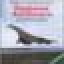

In [59]:
from keras.preprocessing.image import load_img
new_image = load_img(path+'test/airplane/airplane_3.jpg',target_size=(64,64))
new_image

In [196]:
%matplotlib inline
from keras.preprocessing.image import img_to_array
new_image_array = img_to_array(new_image)

In [64]:
plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(new_image_array)
plt.subplot(1,3,2)
plt.imshow(new_image_array[:,:,0])
plt.subplot(1,3,3)
plt.imshow(new_image_array)
plt.set_cmap('nipy_spectral')
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## 0.4 - Make the prediction

In [257]:
import numpy as np
new_image_array_expand = np.expand_dims(new_image_array , axis = 0)
result = model_1[0].predict(new_image_array_expand)
if result[0][0] ==0:
    prediction = 'Its a plane'
if result[0][0] ==1:
    prediction = 'Its a car'
print(prediction)

Its a plane


# 1 - Building the main functions

## 1.1 - For loading the pictures

###  From jpg to array

In [250]:
def load_image_array(path_picture,size_picture):
    '''
    This function take an picture (jpg for exemple) and convert it into array
    '''
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    # Load the picture
    new_image = load_img(path_picture,
                         target_size = (size_picture[0],size_picture[1]))
    
    # convert the picture to array format
    new_image_array = img_to_array(new_image)
    
    return(new_image_array)

### For loading all the pictures of a folder

In [251]:
import os
def pictures_folder(path,size_picture):
    '''
    load all the pictures of a folder and the category of each picture
    the pictures are then transformed into array (to be past after into the RNN)
    '''
    dirs = os.listdir(path)
    for folders in dirs:
        # path of the folder
        path_folder = path+'/'+folders
        size_folder = len(os.listdir(path_folder))
        
        # load the first picture of the folder (as an array)
        image_array = [load_image_array(path_picture = path_folder + '/'+ os.listdir(path_folder)[0],
                                        size_picture = size_picture)]
        image_type = [folders]
        
        # load the other pictures of the folder (as an array)
        for i in range(1,size_folder):
            image_array.append(load_image_array(path_picture = path_folder + '/' + os.listdir(path_folder)[i],
                                                size_picture = size_picture))
            image_type.append(folders)
            
    return([image_array,image_type])

## 1.2 - For the prediction

In [260]:
def prediction_solo(array,model):
    """
    calculate the prediction for a already trained model and a single picture. 
    The names of the predictoin are those of the folders (test and train have to containt the same folders)
    """
    warnings.warn("Test and train have to containt the same folders")
    
    array_expand = np.expand_dims(array , axis = 0)
    result = model[0].predict(array_expand)
    dirs = os.listdir(path)
    
    if result[0][0] <0.5:
        prediction = model[2][0]
    if result[0][0] >=0.5:
        prediction = model[2][1]
    
    return([result,prediction])

# test :
# ------
## from keras.preprocessing.image import load_img
## from keras.preprocessing.image import img_to_array
## path = 'C:/Users/F400244/PycharmProjects/CIFAR10/data/Cifar_small/'
## new_image_array = img_to_array(new_image)
## new_image = load_img(path+'test/airplane/airplane_3.jpg',target_size=(64,64))
## new_image_array = img_to_array(new_image)
## prediction_solo( new_image_array, model_1, path+ '/test')

In [253]:
def prediction_group(picture_list,picture_target,model):
    """
    calculate the prediction for a already trained model and a list of pictures
    the function is based on the prediction_solo function()
    """
    # first we initilise the list which contains the prediction and the probability
    image_pred=[prediction_solo(picture_list[0],model)[1]]   
    image_proba=[prediction_solo(picture_list[0],model)[0]]
    
    # Then we make the prediction for every picture of the list
    for i in range(1,len(picture_list)):
        pred=prediction_solo(picture_list[i],model)
        image_pred.append(pred[1])
        image_proba.append(pred[0])

    # Accuracy
    from sklearn.metrics import accuracy_score
    print(accuracy_score(picture_target, image_pred))
    return([image_proba,image_pred])

# 2 - Building of the CNN

## 2.1 - First CNN

In [277]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

def create_very_small_vgg(num_classes, activation, img_height, img_width, nb_channels, final_activation,path):
    # from keras exemple : https://keras.io/examples/cifar10_cnn/

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = activation, input_shape = (img_height, img_width, nb_channels)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # second convolution block
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # output
    model.add(Flatten())
    model.add(Dense(512, activation = activation))
    model.add(Dropout(0.5))  # high dropout to deal with large dense value
    model.add(Dense(num_classes, activation = final_activation))
    
    return [model,[img_height, img_width, nb_channels],os.listdir(path)]

## 2.2 - Second CNN

In [279]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

def create_small_vgg(num_classes, activation, img_height, img_width, nb_channels, final_activation,path):
    # from keras exemple : https://keras.io/examples/cifar10_cnn/

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = activation, input_shape = (img_height, img_width, nb_channels)))
    model.add(Conv2D(32, (3, 3), padding = 'valid', activation = activation, input_shape = (img_height, img_width, nb_channels)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # second convolution block
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(Conv2D(64, (3, 3), padding = 'valid', activation = activation))

    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # output
    model.add(Flatten())
    model.add(Dense(512, activation = activation))
    model.add(Dropout(0.5))  # high dropout to deal with large dense value
    model.add(Dense(num_classes, activation = final_activation))
    
    return [model,[img_height, img_width, nb_channels],os.listdir(path)]

## 2.3 - Training

In [284]:
model_1 = create_very_small_vgg(num_classes=1,
                                activation='relu',
                                img_height=training_set.image_shape[0],
                                img_width=training_set.image_shape[1],
                                nb_channels=training_set.image_shape[2],
                                final_activation='sigmoid',
                                path = 'C:/Users/F400244/PycharmProjects/CIFAR10/data/Cifar_small/train')
model_2 = create_small_vgg(num_classes=1,
                                activation='relu',
                                img_height=training_set.image_shape[0],
                                img_width=training_set.image_shape[1],
                                nb_channels=training_set.image_shape[2],
                                final_activation='sigmoid',
                                path = 'C:/Users/F400244/PycharmProjects/CIFAR10/data/Cifar_small/train')
print(model_1[1])
print(model_1[2])
model_1[0].summary()
model_2[0].summary()

[64, 64, 3]
['airplane', 'automobile']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 1

In [285]:
from keras.optimizers import Adam
model_1[0].compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

model_2[0].compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [291]:
model_1[0].fit_generator(training_set,
                         steps_per_epoch=214,
                         epochs=100,
                         verbose=1,
                         validation_data=test_set,
                         validation_steps=192)

Epoch 1/100
214/214 [==============================] - 74s 345ms/step - loss: 0.0569 - acc: 0.9806 - val_loss: 0.6594 - val_acc: 0.8481
Epoch 2/100
214/214 [==============================] - 74s 345ms/step - loss: 0.0296 - acc: 0.9903 - val_loss: 0.6593 - val_acc: 0.8468
Epoch 3/100
214/214 [==============================] - 74s 344ms/step - loss: 0.0227 - acc: 0.9930 - val_loss: 0.7058 - val_acc: 0.8343
Epoch 4/100
214/214 [==============================] - 74s 344ms/step - loss: 0.0411 - acc: 0.9865 - val_loss: 0.9761 - val_acc: 0.8403
Epoch 5/100
214/214 [==============================] - 74s 345ms/step - loss: 0.0116 - acc: 0.9974 - val_loss: 0.8195 - val_acc: 0.8548
Epoch 6/100
214/214 [==============================] - 74s 345ms/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.9364 - val_acc: 0.8577
Epoch 7/100
214/214 [==============================] - 74s 344ms/step - loss: 0.0100 - acc: 0.9972 - val_loss: 1.0697 - val_acc: 0.8473
Epoch 8/100
214/214 [===========================

214/214 [==============================] - 72s 337ms/step - loss: 0.0055 - acc: 0.9991 - val_loss: 1.5159 - val_acc: 0.8617
Epoch 61/100
214/214 [==============================] - 72s 337ms/step - loss: 1.2890e-04 - acc: 1.0000 - val_loss: 1.4009 - val_acc: 0.8641
Epoch 62/100
214/214 [==============================] - 72s 337ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 1.3837 - val_acc: 0.8560
Epoch 63/100
214/214 [==============================] - 72s 337ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 1.3729 - val_acc: 0.8604
Epoch 64/100
214/214 [==============================] - 72s 337ms/step - loss: 0.0205 - acc: 0.9961 - val_loss: 1.6517 - val_acc: 0.8439
Epoch 65/100
214/214 [==============================] - 72s 337ms/step - loss: 0.0086 - acc: 0.9980 - val_loss: 1.3375 - val_acc: 0.8573
Epoch 66/100
214/214 [==============================] - 72s 337ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 1.2300 - val_acc: 0.8547
Epoch 67/100
214/214 [============================

In [301]:
from keras.models import load_model
model_1[0].save('model_1.h5')

In [292]:
model_2[0].fit_generator(training_set,
                         steps_per_epoch=214,
                         epochs=100,
                         verbose=1,
                         validation_data=test_set,
                         validation_steps=192)

Epoch 1/100
214/214 [==============================] - 125s 584ms/step - loss: 0.0647 - acc: 0.9802 - val_loss: 0.6181 - val_acc: 0.8574
Epoch 2/100
214/214 [==============================] - 125s 583ms/step - loss: 0.0358 - acc: 0.9879 - val_loss: 0.8455 - val_acc: 0.8460
Epoch 3/100
214/214 [==============================] - 125s 583ms/step - loss: 0.0070 - acc: 0.9982 - val_loss: 1.0837 - val_acc: 0.8509
Epoch 4/100
214/214 [==============================] - 125s 585ms/step - loss: 0.0128 - acc: 0.9956 - val_loss: 1.1037 - val_acc: 0.8566
Epoch 5/100
214/214 [==============================] - 125s 585ms/step - loss: 0.0528 - acc: 0.9815 - val_loss: 1.1281 - val_acc: 0.8306
Epoch 6/100
214/214 [==============================] - 127s 592ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.8646 - val_acc: 0.8501
Epoch 7/100
214/214 [==============================] - 130s 606ms/step - loss: 0.0068 - acc: 0.9973 - val_loss: 1.0893 - val_acc: 0.8563
Epoch 8/100
214/214 [====================

214/214 [==============================] - 125s 583ms/step - loss: 3.3907e-05 - acc: 1.0000 - val_loss: 1.4102 - val_acc: 0.8643
Epoch 61/100
214/214 [==============================] - 125s 582ms/step - loss: 0.0098 - acc: 0.9975 - val_loss: 1.6732 - val_acc: 0.8368
Epoch 62/100
214/214 [==============================] - 125s 582ms/step - loss: 0.0175 - acc: 0.9978 - val_loss: 1.7261 - val_acc: 0.8475
Epoch 63/100
214/214 [==============================] - 125s 583ms/step - loss: 0.0328 - acc: 0.9964 - val_loss: 1.8494 - val_acc: 0.8452
Epoch 64/100
214/214 [==============================] - 125s 583ms/step - loss: 0.0467 - acc: 0.9934 - val_loss: 1.6265 - val_acc: 0.8652
Epoch 65/100
214/214 [==============================] - 125s 583ms/step - loss: 0.0161 - acc: 0.9977 - val_loss: 1.5843 - val_acc: 0.8625
Epoch 66/100
214/214 [==============================] - 125s 582ms/step - loss: 0.0189 - acc: 0.9979 - val_loss: 1.9228 - val_acc: 0.8534
Epoch 67/100
214/214 [=====================

In [302]:
from keras.models import load_model
model_2[0].save('model_2.h5')

# 2.0 - Application

In [255]:
image_array,image_type = pictures_folder(path= path + '/test',size_picture=model_1[1])

In [273]:
prediction_model1 = prediction_group(picture_list=image_array,picture_target=image_type,model=model_1)
print(prediction_model1[0][0])
print(prediction_model1[1][0])

C:\ProgramData\anaconda3\envs\formation_cnn\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Test and train have to containt the same folders
  


0.8202247191011236
[[1.]]
automobile


# Transfert learning
First we import an already buid CNN. Here it's the VGG16

In [166]:
from keras.applications.vgg16 import VGG16
classifier = VGG16()

553467904/553467096 [==============================] - 475s 1us/step


In [167]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

After that we suppres the last layer of the model (so here, we supress the dense layer). In fact, what we realy do is first we save the name of the last layer. After that, we create an empty Sequential Keras NN. And finally we add to this empty model all the layer of the VGG16 expect the last layer :

In [182]:
last_layer = str(classifier.layers[-1])
model_2 = Sequential()
for layer in classifier.layers:
    if str(layer)!=last_layer:
        model_2.add(layer)

In [183]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

As we can see via the model_2 summary, we have replicate the VGG16 structure (and weight) expect the last layer.
Now we specify to python that we don't want to change the weight of the actual layer of model_2.

In [184]:
for layer in model_2.layers:
    layer.trainable = False

And to finish we now add a Dense layer to model_2 (and this one will be trainable)

In [185]:
model_2.add(Dense(1,activation='sigmoid'))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

Now we just have to compile and train our new model

In [186]:
training_set2 = train_datagen.flow_from_directory(path+'train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set2 = train_datagen.flow_from_directory(path+'test',
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'binary')
from keras.optimizers import Adam

model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

model_2.fit_generator(training_set2,
                      steps_per_epoch=214,
                      epochs=2,
                      verbose=1,
                      validation_data=test_set2,
                      validation_steps=192)

Found 214 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Epoch 1/2
214/214 [==============================] - 3349s 16s/step - loss: 0.5020 - acc: 0.7549 - val_loss: 0.4752 - val_acc: 0.7785
Epoch 2/2
214/214 [==============================] - 3335s 16s/step - loss: 0.3869 - acc: 0.8279 - val_loss: 0.4024 - val_acc: 0.8254


In [187]:
prediction_model2 = prediction_group(picture_list=image_array,picture_target=image_type,model=model_2)

ValueError: Error when checking input: expected input_1 to have shape (224, 224, 3) but got array with shape (64, 64, 3)